In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
import random, time, datetime, os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification 
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from matplotlib import pyplot as plt

2023-05-10 22:07:45.263293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
seed = 45
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
tf.random.set_seed(seed)

In [5]:
df = pd.read_csv("../data/figlang_all.tsv", sep="\t", encoding="utf-8")
print(df.shape)
print(df["label"].value_counts())
df.head()

(10848, 4)
0    6506
1    2212
2     884
3     625
4     621
Name: label, dtype: int64


,text,label,label_binary,source
0,I can't believe my ex didn't pay his car note ...,0,0,Sarcasm_premise
1,But then the paper would not find out about yo...,0,0,Idiom_premise
2,Last week my kid said some really mean things ...,0,0,CreativeParaphrase_premise
3,"The gravy was so fatty, it made the meat taste...",0,0,Metaphor_premise
4,He pulls a giant disc out and flashes it like ...,3,1,Simile_hypothesis


In [6]:
df_train = pd.read_csv("../data/figlang_train.tsv", sep="\t", encoding="utf-8")
print(df_train.shape)
print(df_train["label"].value_counts())
df_train.head()

(8678, 4)
0    5186
1    1762
2     714
3     517
4     499
Name: label, dtype: int64


,text,label,label_binary,source
0,That building looks very strong,0,0,Simile_premise
1,I was really agonizing over this decision for ...,0,0,Metaphor_premise
2,I was so cheerful when I came outside this mor...,1,1,Sarcasm_hypothesis
3,Their language broadcasts us to believe them.,4,1,Metaphor_hypothesis
4,"For centuries, the ruler has made life like a ...",3,1,Simile_hypothesis


In [7]:
df_test = pd.read_csv("../data/figlang_test.tsv", sep="\t", encoding="utf-8")
print(df_test.shape)
print(df_test["label"].value_counts())
df_test.head()

(2170, 4)
0    1320
1     450
2     170
4     122
3     108
Name: label, dtype: int64


,text,label,label_binary,source
0,My considerate roommate cooked some meat with ...,1,1,Sarcasm_hypothesis
1,The spy was very quiet,0,0,Simile_premise
2,Look at lucy - very skinny and slender.,0,0,Idiom_premise
3,"Turns out, tag between super heroes can get li...",3,1,Simile_hypothesis
4,"Allister knows nothing about wine, he is a tee...",0,0,Metaphor_premise


# 1. Set the model to use

**Uncomment one of the lines below to set the model.**

In [8]:
#MODEL_NAME = "bert-base-uncased" 
#MODEL_NAME = "roberta-base" 
MODEL_NAME = "xlnet-base-cased" 

# 2. Train model

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

XLNetTokenizerFast(name_or_path='xlnet-base-cased', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '<sep>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False), 'additional_special_tokens': ['<eop>', '<eod>']})

In [10]:
df[df["label"]!=0].value_counts("label")

label
1    2212
2     884
3     625
4     621
dtype: int64

In [11]:
test_max_len = 0

for text in df["text"]:
    input_ids = tokenizer.encode(text, 
                                 add_special_tokens=True)
    test_max_len = max(test_max_len, len(input_ids))

print('Max sentence length: ', test_max_len)

Max sentence length:  59


In [12]:
# Maximal length of input sequence
MAX_LEN = test_max_len

# Number of labels 
NUM_LABELS = 4

# Specifying batch size: For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 16 

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

In [13]:
def get_text_and_label(df):
    df_figlang_only = df.loc[df["label"] != 0]
        
    # Re-map the label to start from 0, otherwise the training does not work:
    label_map = {1: 0, 
                 2: 1,
                 3: 2,
                 4: 3}
        
    df_figlang_only["label"] = df_figlang_only["label"].map(label_map)
        
    X = df_figlang_only["text"].values
    y = df_figlang_only["label"].values
        
    return X, y

In [14]:
X, y = get_text_and_label(df_train)
    
print(np.unique(y))
print(X.shape)
print(y.shape)

[0 1 2 3]
(3492,)
(3492,)


/tmp/ipykernel_56420/2161799642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_figlang_only["label"] = df_figlang_only["label"].map(label_map)


In [15]:
def tokenize(texts, tokenizer, max_len):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every text...
    for idx, text in enumerate(texts):
        encoded_dict = tokenizer.encode_plus(
            text,                      # Sentence to encode.
            add_special_tokens = True, 
            padding = "max_length",
            truncation = True,
            max_length = max_len,
            return_attention_mask = True,
            return_tensors = 'pt')
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert to tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    return input_ids, attention_masks

In [16]:
input_ids, attention_masks = tokenize(texts=X, tokenizer=tokenizer, max_len=MAX_LEN)
labels = torch.tensor(y)

# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=1, test_size=0.2) 

# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=1, test_size=0.2)

print("Shape of training and validation set:")
print(train_inputs.shape)
print(train_labels.shape)
print(validation_inputs.shape)
print(validation_labels.shape)

print("\nShape of attention masks:")
print(len(train_masks))
print(len(validation_masks))

Shape of training and validation set:
torch.Size([2793, 59])
torch.Size([2793])
torch.Size([699, 59])
torch.Size([699])

Shape of attention masks:
2793
699


In [17]:
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [18]:
# Load model for sequence classification, the pretrained model with a single linear classification layer on top. 

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels = NUM_LABELS, 
    output_attentions = False, 
    output_hidden_states = True,
)
    
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,   # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8   # args.adam_epsilon  - default is 1e-8.
                )

In [20]:
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test 
    # (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        # PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    #token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    ### ----- Qi: add the following line to get detailed classification report -----
    eval_predictions, eval_true_labels = [], []
    ### END QI

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            #token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        ### ----- Qi: add the following line to get detailed classification report -----
        eval_predictions.append(logits)
        eval_true_labels.append(label_ids) 
        ### END QI
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    ### ----- Qi: add the following line to get detailed classification report -----
    eval_flat_predictions = np.concatenate(eval_predictions, axis=0) 
    eval_flat_predictions = np.argmax(eval_flat_predictions, axis=1).flatten() 
    eval_flat_true_labels = np.concatenate(eval_true_labels, axis=0) 
    ### END QI
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.8f}".format(eval_accuracy/nb_eval_steps))
    print("  Macro-F1: {0:.8f}".format(f1_score(eval_flat_true_labels, eval_flat_predictions, average="macro")))###
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    
print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    175.    Elapsed: 0:00:04.
  Batch    80  of    175.    Elapsed: 0:00:06.
  Batch   120  of    175.    Elapsed: 0:00:09.
  Batch   160  of    175.    Elapsed: 0:00:12.

  Average training loss: 0.41
  Training epoch took: 0:00:13

Running Validation...
  Accuracy: 0.93969525
  Macro-F1: 0.90989673
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    175.    Elapsed: 0:00:03.
  Batch    80  of    175.    Elapsed: 0:00:06.
  Batch   120  of    175.    Elapsed: 0:00:10.
  Batch   160  of    175.    Elapsed: 0:00:15.

  Average training loss: 0.14
  Training epoch took: 0:00:17

Running Validation...
  Accuracy: 0.94679752
  Macro-F1: 0.92114731
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    175.    Elapsed: 0:00:04.
  Batch    80  of    175.    Elapsed: 0:00:08.
  Batch   120  of    175.    Elapsed: 0:00:12.
  Batch   160  of    175.    Elapsed: 

# 3. Get performance on test set

In [23]:
X_test, y_test = get_text_and_label(df_test)

print(np.unique(y_test))
print(X_test.shape)
print(y_test.shape)

[0 1 2 3]
(850,)
(850,)


/tmp/ipykernel_56420/2161799642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_figlang_only["label"] = df_figlang_only["label"].map(label_map)


In [24]:
input_ids, attention_masks = tokenize(texts=X_test, tokenizer=tokenizer, max_len=MAX_LEN)
y_test = torch.tensor(y_test)

# Set the batch size.  
#batch_size = 32  ###

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, y_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        #token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 850 test sentences...
    DONE.


In [26]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Print results:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
f1 = f1_score(flat_true_labels, flat_predictions, average="macro")

print("Accuracy:",  round(accuracy, 10))
print()

print("Macro-F1:", round(f1, 10))
print()

print("Detail:")
print(classification_report(flat_true_labels, flat_predictions))

Accuracy: 0.9647058824

Macro-F1: 0.9489780575

Detail:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       450
           1       0.93      0.91      0.92       170
           2       0.94      0.99      0.96       108
           3       0.94      0.89      0.92       122

    accuracy                           0.96       850
   macro avg       0.95      0.95      0.95       850
weighted avg       0.96      0.96      0.96       850



# 4. Save results

**Save confusion matrix:**

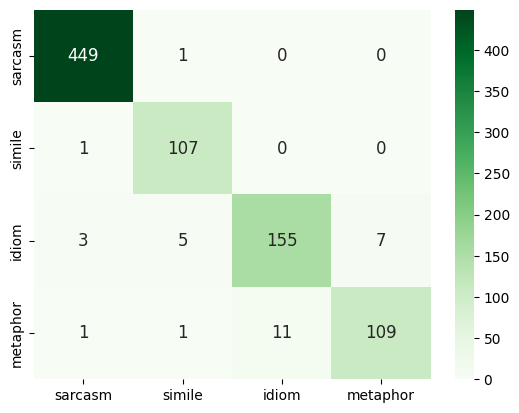

In [27]:
tick_labels = ["sarcasm", "simile", "idiom", "metaphor"]
labels=[0, 2, 1, 3] # Group those with cues (sarcasm, simile) together, and those without cues (idiom, metaphor) together

cm = confusion_matrix(flat_true_labels, flat_predictions, labels=labels) 
sns.heatmap(cm, annot=True, fmt="d", yticklabels=tick_labels, xticklabels=tick_labels, cmap="Greens", annot_kws={'fontsize': 12})

plt.savefig("../results/classification_results/confusion_matrix_testset_" + MODEL_NAME + ".pdf")

**Save classification report:**

In [28]:
report = classification_report(flat_true_labels, flat_predictions, output_dict=True)
df_result = pd.DataFrame(report).transpose()
df_result.to_csv("../results/classification_results/classification_report_testset_" + MODEL_NAME + ".tsv", 
                sep = "\t", encoding="utf-8")

**Save predicted labels:**

In [29]:
df_pred = pd.DataFrame({"label": flat_true_labels,
                        "text": X_test,
                        "pred": flat_predictions})

df_pred.to_csv("../results/classification_results/predicted_labels_testset_" + MODEL_NAME + ".tsv",
               sep="\t", encoding="utf-8", index=False)

df_pred

,label,text,pred
0,0,My considerate roommate cooked some meat with ...,0
1,2,"Turns out, tag between super heroes can get li...",2
2,1,Then as I gathered courage to go down I realiz...,1
3,0,It's absolutely fine that I got an older car f...,0
4,3,He was in a black mood.,3
...,...,...,...
845,0,I was overjoyed when someone backed into my ne...,0
846,0,I almost crashed my car because the guy that c...,0
847,2,You can freely switch between them but the res...,2
848,0,I was so delighted when I came home to find my...,0


**Save model:**

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '../results/models/' + MODEL_NAME + "-figlang" 

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ../results/models/xlnet-base-cased-figlang
